In [1]:
import os
is_running_on_colab = 'COLAB_GPU' in os.environ
print('Running on CoLab?', is_running_on_colab)

Running on CoLab? False


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from torch.utils.data import *
from imutils import paths
from typing import Union
import torch
import torch.nn as nn
import time
import torch.optim as optim
from tqdm.notebook import tqdm


if is_running_on_colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/license_plate/data/'
  test_path = '/content/gdrive/MyDrive/license_plate/testdata/'
else:
  current_dir = os.getcwd()
  data_path = os.path.join(current_dir,'dataset','dataset_local','data')
  test_path = os.path.join(current_dir,'dataset','dataset_local','testdata')
#simple directory check for the data_files

def check_directories_exist(*paths):
    for path in paths:
        if not os.path.isdir(path):
            print(f"The directory {path} does not exist.")

check_directories_exist(data_path, test_path)

data_link = "https://drive.google.com/open?id=1rdEsCUcIUaYOVRkx5IMTRNA7PcGMmSgc"

In [3]:

class labelFpsDataLoader(Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in paths.list_images(img_dir[i])]
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        # Get image name
        print("loading from path:", self.img_paths[index])
        img_name = self.img_paths[index]
        print("img_name:", img_name)
        img = cv2.imread(img_name)
        #show img
        plt.imshow(img)
        # Resize image
        resizedImage = cv2.resize(img, self.img_size)
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0

        if is_running_on_colab:
            iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
            [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
        else: 
            iname = img_name.rsplit('\\', 1)[-1].rsplit('.', 1)[0].split('-')
            [leftUp, rightDown] = [[int(eel) for eel in el.split('_')] for el in iname[1:3]]

        # Find leftUp and rightDown from file-name of original image

        # Find original width and original height of original image
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]

        # Find scale values for width and height
        scale_height, scale_width = self.img_size[1] / ori_h, self.img_size[0] / ori_w

        scaled_leftUp = (int(leftUp[0] * scale_width), int(leftUp[1] * scale_height))
        scaled_rightDown = (int(rightDown[0] * scale_width), int(rightDown[1] * scale_height))

        # All four values of leftUp and rightDown scaled in 1 vector
        scaled_labels = (scaled_leftUp, scaled_rightDown)
        # scaled_labels = [int(leftUp[0] * scale_x, leftUp[1] * scale_y), (rightDown[0] * scale_x, rightDown[1] * scale_y)]

        # Flatten scaled_labels into a 1D list
        flattened_labels = [coordinate for point in scaled_labels for coordinate in point]

        # Convert the 1D list to a tensor and reshape it to (1, 4)
        scaled_labels_tensor = torch.tensor(flattened_labels, dtype=torch.float32)


        return resizedImage, scaled_labels_tensor, img_name
    

In [4]:
# Initialize your dataset
img_dir = [data_path]  # Replace with actual paths to your image directories
img_size = (224, 224)  # Replace with your desired image size
dataset = labelFpsDataLoader(img_dir=img_dir, imgSize=img_size)

# Test the length of the dataset
print(f"Length of dataset: {len(dataset)}")

# Test getting an item
try:
    # Retrieve the first item
    img, labels, img_name = dataset[0]

    # Check the shapes and types
    print(f"Image shape: {img.shape}")
    print(f"Labels: {labels}")
    print(f"Image name: {img_name}")

    # If the code reaches this point, the item has been retrieved successfully
    print("Item retrieval successful.")
except Exception as e:
    # If there is any error, print it out
    print(f"An error occurred: {e}")

Length of dataset: 427
loading from path: c:\Users\au616584\OneDrive - Aarhus Universitet\Datalogi\Deep_learning\License_plate\dataset\dataset_local\data\0028-0_10-279_495_356_526-350_526_279_525_285_495_356_496-0_0_20_25_23_29_31-69-13.jpg
img_name: c:\Users\au616584\OneDrive - Aarhus Universitet\Datalogi\Deep_learning\License_plate\dataset\dataset_local\data\0028-0_10-279_495_356_526-350_526_279_525_285_495_356_496-0_0_20_25_23_29_31-69-13.jpg
Image shape: (224, 224, 3)
Labels: tensor([ 0.,  1., 86., 95.])
Image name: c:\Users\au616584\OneDrive - Aarhus Universitet\Datalogi\Deep_learning\License_plate\dataset\dataset_local\data\0028-0_10-279_495_356_526-350_526_279_525_285_495_356_496-0_0_20_25_23_29_31-69-13.jpg
Item retrieval successful.


: 

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def plot_img_and_boundingbox(image, labels):
    numpy_array = image.cpu().detach().numpy()

    cv2_image = cv2.cvtColor(numpy_array, cv2.COLOR_RGB2BGR)

    # Extract numerical values from tensors and convert to integers
    leftUp = (int(labels[0]),int(labels[1]))
    rightDown = (int(labels[2]),int(labels[3]))
    # Draw rectangle on the image
    new_image = cv2.rectangle(cv2_image, leftUp, rightDown, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.show()

# scaled_labels = batch[1][0]
# plot_img_and_boundingbox(image, scaled_labels)

In [17]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\au616584/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [18]:
net = nn.Sequential(
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(1024, out_features=4, bias=True),
)
model.classifier = net

In [19]:
#Sets model to training mode,e this is important for layers that have different functionalities depending on training or eval. for example BatchNorm
model.train()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [20]:
layers_of_classifier = 4
for i, param in enumerate(model.parameters()):
    if i < len(list(model.parameters())) - layers_of_classifier:
        param.requires_grad = False
    else:
        param.requires_grad = True

number_of_layers = len(list(enumerate(model.parameters())))
print(f"Total number of layers is {number_of_layers}")
print(f"Number of pretrained base layers is {number_of_layers - layers_of_classifier}")

Total number of layers is 160
Number of pretrained base layers is 156


In [21]:
def check_requires_grad():
  for name, param in model.named_parameters(): # Just to check
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#check_requires_grad()

In [22]:
def bb_intersection_over_union(boxA, boxB): # https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def calculate_true_positives_in_batch(y_pred, y_batch):
  threshold = 0.5
  true_positive_amount = 0
  for i in range(y_pred.shape[0]):
    y_pred_numpy = y_pred[i].cpu().detach().numpy()
    y_batch_numpy = y_batch[i].cpu().detach().numpy()
    iou = bb_intersection_over_union(y_pred_numpy, y_batch_numpy)
    if iou > threshold:
      true_positive_amount +=1
  return true_positive_amount

#wrapper of tqdm to enable toggling it off easily
def toggle_tqdm(iterable, use_tqdm=True):
  if use_tqdm:
    return tqdm(iterable)
  else:
    return iterable

def calculate_loss_and_accuracy(loader):
  total_loss = 0
  total_true_positives = 0
  total_samples = 0

  for X_batch_, y_batch, img_name in loader:
      X_batch = X_batch_.permute(0,3,1,2).to(device)
      y_batch = y_batch.to(device)
      y_pred = model(X_batch)

      total_true_positives += calculate_true_positives_in_batch(y_pred, y_batch)

      loss = loss_fn(y_pred, y_batch)
      total_loss += loss.item() * len(y_batch)  # Accumulate scaled loss
      total_samples += len(y_batch)  # Accumulate number of samples
  sample_loss = total_loss / total_samples  # Calculate average loss
  accuracy = total_true_positives / total_samples
  return sample_loss, accuracy

In [23]:

# Determine hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)

# Define dataloader for training
data_loader = labelFpsDataLoader([data_path],(500,1000))
trainloader = DataLoader(data_loader, batch_size=8, shuffle=True, num_workers=0)

# Determine subset?? (mabeto??)
subset = not is_running_on_colab
subset_data = Subset(data_loader, indices=range(30))
if subset:
  trainloader =DataLoader(subset_data, batch_size=8, shuffle=True, num_workers=0)
# dataiter = iter(trainloader)
# first_batch = next(dataiter)

# # Now you can access the data and target tensors
# X_batch, y_batch, img_name = first_batch

# print(X_batch.shape)
# Define dataloader for validation
test_loader = labelFpsDataLoader([test_path],(500,1000))
validationloader = DataLoader(test_loader, batch_size=64, shuffle=True, num_workers=1)

# Define model and hyperparameters
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
model.train()
model.to(device)

use_tqdm = False
# Train
def train_model(n_epochs):
  test_loss_history = []
  val_loss_history = []
  test_accuracy_history = []
  val_accuracy_history = []
  i = 0
  for epoch in toggle_tqdm(range(n_epochs), use_tqdm):
    print("epoch:", i)
    for X_batch, y_batch, img_name in toggle_tqdm(trainloader, use_tqdm):
      X_batch = X_batch.permute(0,3,1,2).to(device) # Needs to have shape [batch_size, channels, height, width]
      y_batch = y_batch.to(device)
      y_pred = model(X_batch)
      loss = loss_fn(y_pred,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # In-sample & out-sample loss calculation
    model.eval()  # Switch to evaluation mode to disable features like dropout
    with torch.no_grad():  # Disable gradient calculation to save memory
        # In sample
        in_sample_loss, in_sample_accuracy = calculate_loss_and_accuracy(trainloader)
        test_loss_history.append(in_sample_loss)
        test_accuracy_history.append(in_sample_accuracy)
        print(f'Epoch {epoch+1}, In-sample Loss : {in_sample_loss:.4f}, In-sample accuracy : {in_sample_accuracy:.4f}' )

        # Out sample
        out_sample_loss, out_sample_accuracy = calculate_loss_and_accuracy(validationloader)
        val_loss_history.append(out_sample_loss)
        val_accuracy_history.append(out_sample_accuracy)
        print(f'Epoch {epoch+1}, Out-sample Loss: {out_sample_loss:.4f}, Out-sample accuracy : {out_sample_accuracy:.4f}')
    i += 1
  return test_loss_history, val_loss_history, test_accuracy_history, val_accuracy_history

# Train decoder (initial)
decoder_epochs = 2
train_model(decoder_epochs)
print("DECODER TRAINING DONE")

# Unfreeze encoder
for i, param in enumerate(model.parameters()):
  param.requires_grad = True

# Train encoder
n_epochs = 8
test_loss_history, val_loss_history, test_accuracy_history, val_accuracy_history = train_model(n_epochs)





using device:  cpu
epoch: 0
loading from path: c:\Users\au616584\OneDrive - Aarhus Universitet\Datalogi\Deep_learning\License_plate\dataset\dataset_local\data\0029-1_1-296_482_376_513-376_513_296_511_296_482_376_484-0_0_7_11_33_32_30-83-15.jpg


IndexError: list index out of range

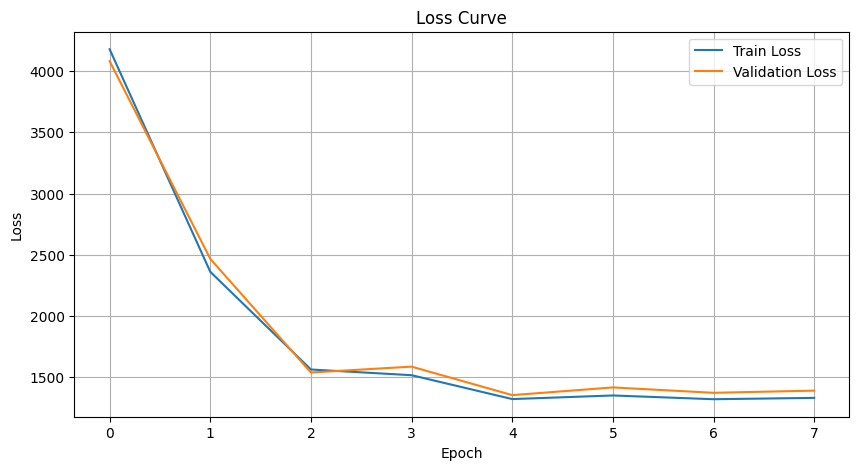

In [ ]:
plt.figure(figsize=(10, 5))
#plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.plot(test_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Add a legend to differentiate between train and validation loss
plt.show()

torch.Size([1, 1000, 500, 3])
torch.Size([1, 4])
torch.Size([1, 3, 1000, 500])


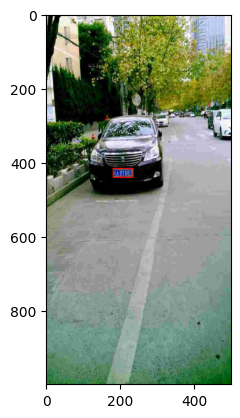

In [ ]:
# Print a validation image with its predicted labels

validationloader = DataLoader(test_loader, batch_size=1, shuffle=True, num_workers=1)

validationloader_iter = iter(validationloader)

batch = next(validationloader_iter)

X_batch, y_batch, _ = batch
print(X_batch.shape)
print(y_batch.shape)

image = batch[0][0]
labels = batch[1][0]

# Get predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
print(X_batch.shape)
pred = model(X_batch)

plot_img_and_boundingbox(image, labels)

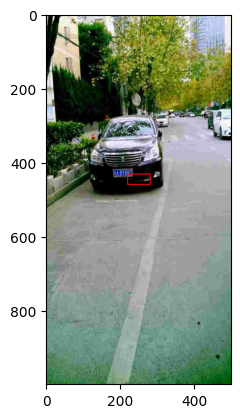

0


In [ ]:
plot_img_and_boundingbox(image,pred[0])

print(calculate_true_positives_in_batch(labels.view(1,4),pred[0].view(1,4))) # Need to change view since we dont have batch